### Application
used https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import pandas as pd
mer_b0=pd.read_csv('mer_weather.csv')

In [2]:
dataset=mer_b0.drop(['site_id'], axis=1)

In [3]:
dataset=dataset.set_index('timestamp')

In [4]:
dataset.head()

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,
2016-01-01 00:00:00,28.10,15.6,-5.6,0.0,1015.3,270.0,3.6
2016-01-01 01:00:00,26.57,13.9,-5.6,0.0,1015.6,270.0,4.1
2016-01-01 02:00:00,25.73,13.3,-5.6,0.0,1016.0,270.0,3.1
2016-01-01 03:00:00,25.96,12.2,-6.1,0.0,1016.6,280.0,3.1
2016-01-01 04:00:00,25.59,11.7,-6.7,0.0,1017.0,270.0,3.1


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

window_size=24

# frame as supervised learning
reframed = series_to_supervised(scaled, window_size, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

    var1(t-24)  var2(t-24)  var3(t-24)  var4(t-24)  var5(t-24)  var6(t-24)  \
24    0.090175    0.297778    0.286420    0.007519    0.553631    0.750000   
25    0.082777    0.260000    0.286420    0.007519    0.564014    0.750000   
26    0.078716    0.246667    0.286420    0.007519    0.577854    0.750000   
27    0.079828    0.222222    0.274074    0.007519    0.598614    0.777778   
28    0.078039    0.211111    0.259259    0.007519    0.612457    0.750000   

    var7(t-24)  var1(t-23)  var2(t-23)  var3(t-23)    ...     var6(t-2)  \
24    0.233766    0.082777    0.260000    0.286420    ...      0.000000   
25    0.266234    0.078716    0.246667    0.286420    ...      0.000000   
26    0.201299    0.079828    0.222222    0.274074    ...      0.750000   
27    0.201299    0.078039    0.211111    0.259259    ...      0.694444   
28    0.201299    0.081520    0.173333    0.259259    ...      0.694444   

    var7(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
24   0.0

In [6]:
#split train and test
values = reframed.values
n_train_hours = 250*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window_size, int(train_X.shape[1]/window_size)))
test_X = test_X.reshape((test_X.shape[0], window_size, int(test_X.shape[1]/window_size)))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6000, 24, 7) (6000,) (2735, 24, 7) (2735,)


In [15]:
train_X

array([[[0.09017503, 0.2977778 , 0.28641978, ..., 0.55516016,
         0.75      , 0.23376623],
        [0.08277729, 0.26      , 0.28641978, ..., 0.5658363 ,
         0.75      , 0.26623377],
        [0.07871579, 0.24666667, 0.28641978, ..., 0.58007115,
         0.75      , 0.2012987 ],
        ...,
        [0.09472005, 0.32222223, 0.38271606, ..., 0.6405694 ,
         0.        , 0.        ],
        [0.09472005, 0.34666666, 0.39753088, ..., 0.62989324,
         0.        , 0.        ],
        [0.09447828, 0.3711111 , 0.40987656, ..., 0.62989324,
         0.        , 0.        ]],

       [[0.08277729, 0.26      , 0.28641978, ..., 0.5658363 ,
         0.75      , 0.26623377],
        [0.07871579, 0.24666667, 0.28641978, ..., 0.58007115,
         0.75      , 0.2012987 ],
        [0.07982786, 0.22222221, 0.27407408, ..., 0.6014235 ,
         0.7777778 , 0.2012987 ],
        ...,
        [0.09472005, 0.34666666, 0.39753088, ..., 0.62989324,
         0.        , 0.        ],
        [0.0

In [16]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4800, 24, 7) (4800,) (3935, 24, 7) (3935,)


In [7]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [8]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import Sequential

# design network - 3 layered lstm
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
history = model.fit(train_X, train_y, epochs=70, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)




Train on 6000 samples, validate on 2735 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/70
 - 16s - loss: 0.1167 - val_loss: 0.1090
Epoch 2/70
 - 9s - loss: 0.0867 - val_loss: 0.0819
Epoch 3/70
 - 9s - loss: 0.0725 - val_loss: 0.0707
Epoch 4/70
 - 9s - loss: 0.0643 - val_loss: 0.0719
Epoch 5/70
 - 9s - loss: 0.0612 - val_loss: 0.0728
Epoch 6/70
 - 9s - loss: 0.0598 - val_loss: 0.0592
Epoch 7/70
 - 9s - loss: 0.0553 - val_loss: 0.0590
Epoch 8/70
 - 9s - loss: 0.0538 - val_loss: 0.0598
Epoch 9/70
 - 9s - loss: 0.0550 - val_loss: 0.0562
Epoch 10/70
 - 9s - loss: 0.0540 - val_loss: 0.0541
Epoch 11/70
 - 9s - loss: 0.0528 - val_loss: 0.0531
Epoch 12/70
 - 9s - loss: 0.0502 - val_loss: 0.0551
Epoch 13/70
 - 9s - loss: 0.0485 - val_loss: 0.0546
Epoch 14/70
 - 9s - loss: 0.0471 - val_loss: 0.0530
Epoch 15/70
 - 9s - loss: 0.0444 - val_loss: 0.0496
Epoch 16/70
 - 9s - loss: 0.0439 - val_loss: 0.0461
Epoch 17/70
 - 9s - loss: 0.0420 - val_loss: 0.0448
Epoch 18/70
 - 9s - loss: 0.

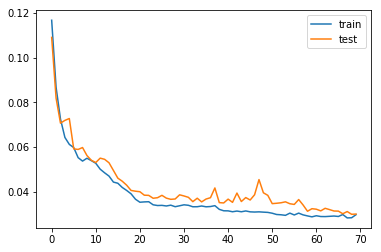

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], window_size*test_X.shape[2]))
test_X[:,1:]
# # invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:7]), axis=1)
inv_yhat
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:7]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.678


### EDA

In [13]:
r=np.concatenate((yhat, test_X[:, 1:7]), axis=1)
r=scaler.inverse_transform(r)
r=pd.DataFrame(r)

In [14]:
len(r[0])

2735

In [15]:
def plot_series(time, series, format="-",start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("meter reading")
    plt.grid(True)

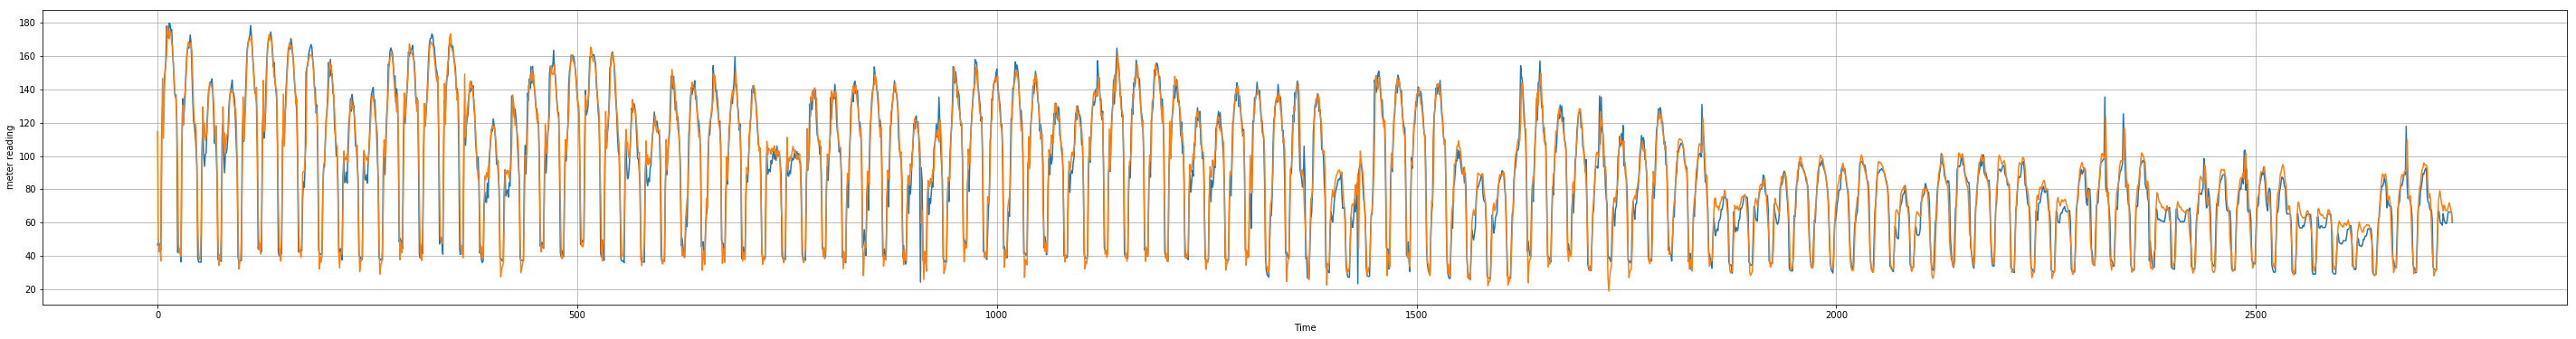

In [16]:
import matplotlib.pyplot as plt
series = inv_y
time_step=[]
for x in range(len(series)):
    time_step.append(x)
time=np.array(time_step)
plt.figure(figsize=(50, 6))
plot_series(time,series)
plot_series(time,r[0])